In [ ]:
## Create a Chatbot with tool capabilities from arxiv, wikipedia search, Taviliy and some functions. 
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun 
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct-agent"

In [4]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)
arxiv.invoke("Attention is all you need")

arxiv


"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [7]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=250)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)
print(wiki.name)

wiki.invoke("What is meachine learning?")

wikipedia


'No good Wikipedia Search Result was found'

In [10]:
## TavilySearch results 
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults() 

tavily.invoke("Provide me recent AI news for Oct 7th 2025?")

[{'title': 'AI Today in 5: October 7, 2025, The AI for HR Edition',
  'url': 'https://www.jdsupra.com/legalnews/ai-today-in-5-october-7-2025-the-ai-f-22480/',
  'content': '3 hours ago—Welcome toAIToday in 5, the newest edition to the Compliance Podcast Network. Each day, Tom Fox will bring you 5 stories aboutAI,',
  'score': 0.8025714},
 {'title': "Novice Investor's Digest For Tuesday, October 7: AI News ...",
  'url': 'https://www.forbes.com/sites/catherinebrock/2025/10/07/novice-investors-digest-for-tuesday-october-7-ai-news-continues-to-dominate/',
  'content': '# Novice Investor’s Digest For Tuesday, October 7: AI News Continues To Dominate\n\nByCatherine Brock,\n\nContributor.\n\nHigh-tech artificial intelligence concept illustration\n\nU.S. stocks were mixed Monday as AI news continues to dominate financial headlines. The large-cap S&P 500 index rose 0.4%, the technology-focused Nasdaq Composite rose 0.7%, and the Dow Jones Industrial Average, the blue-chip index, fell 0.1%. [..

In [25]:
def add(a:int, b: int) -> int: 
    """ Add a and b 
    Args: 
        a (int): first number 
        b (int): second number

    Returns:
        int: sum of a and b
    """
    return a + b 

def subtract(a:int, b: int) -> int: 
    """ Subtract b from a
    Args: 
        a (int): first number 
        b (int): second number

    Returns:
        int: difference of a and b
    """
    return a - b 

def multiply(a:int, b: int) -> int: 
    """ Multiply a and b
    Args: 
        a (int): first number 
        b (int): second number

    Returns:
        int: multiplication of a and b
    """
    return a * b 

In [26]:
## Combine all the tools in a list. 
tools = [arxiv, wiki, tavily, add, subtract, multiply] 


In [12]:
## Initialize the LLM
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b") 

llm_with_tools = llm.bind_tools(tools=tools) 


In [ ]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news?", name="Human")]).tool_calls 


[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'jhhbn4vyk',
  'type': 'tool_call'}]

In [ ]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news?", name="Human")]).tool_calls 

In [30]:
### Entier Chatbot with LangGraph 

from typing_extensions import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages 

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END 
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition 

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def tools_calling_llm(state:State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

### Node definitions 
builder=StateGraph(State)
builder.add_node("tools_calling_llm", tools_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tools_calling_llm") 
builder.add_conditional_edges("tools_calling_llm", tools_condition) 
##builder.add_edge("tools", END)  ##  Regular call. 
builder.add_edge("tools", "tools_calling_llm")    ##  Agentic call 



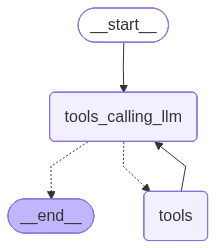

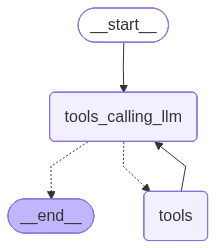

In [33]:
from langgraph.checkpoint.memory import MemorySaver 

memory = MemorySaver()

graph_builder = builder.compile(checkpointer=memory) 
display(Image(graph_builder.get_graph().draw_mermaid_png()))

graph_builder_memory = builder.compile(checkpointer=memory) 
display(Image(graph_builder_memory.get_graph().draw_mermaid_png()))



In [20]:
result_messages = graph_builder.invoke({"messages": [HumanMessage(content="what is the attention is all you need.", name="Human")]})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()

================================ Human Message =================================
Name: Human

what is the attention is all you need.
================================== Ai Message ==================================
Tool Calls:
  arxiv (mfmkdty11)
 Call ID: mfmkdty11
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [21]:
result_messages = graph_builder.invoke({"messages": [HumanMessage(content="1706.03762")]})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (vr3t73rb0)
 Call ID: vr3t73rb0
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [22]:
result_messages = graph_builder.invoke({"messages": [HumanMessage(content="Provide me top 10 recent AI news for Oct-2025")]})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()

================================ Human Message =================================

Provide me top 10 recent AI news for Oct-2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8paf1g6s5)
 Call ID: 8paf1g6s5
  Args:
    query: top 10 recent AI news October 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News Briefs BULLETIN BOARD for October 2025", "url": "https://radicaldatascience.wordpress.com/2025/10/03/ai-news-briefs-bulletin-board-for-october-2025-2/", "content": "[10/2/2025] Mira Murati’s Stealth AI Lab Launches Its First Product – The tool, called Tinker, automates fine-tuning of frontier open-source models like Meta’s Llama and Alibaba’s Qwen via supervised and reinforcement learning, letting users run downloaded custom models locally or elsewhere.\n\nKey details: [...] [10/3/2025] OpenAI Hits $500 Billion Valuation – 

In [23]:
result_messages = graph_builder.invoke({"messages": [HumanMessage(content="What is Machine Learning?")]})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (2d8pk5qd4)
 Call ID: 2d8pk5qd4
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks wit


In [28]:
result_messages = graph_builder.invoke({"messages": [HumanMessage(content="Provide me top 10 recent AI news for Oct-2025, and then calculate 10 plus 15 and then multiply the result by 5, and then subtract 20 from it.")]})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()

================================ Human Message =================================

Provide me top 10 recent AI news for Oct-2025, and then calculate 10 plus 15 and then multiply the result by 5, and then subtract 20 from it.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (qb2pybhy5)
 Call ID: qb2pybhy5
  Args:
    query: top 10 recent AI news October 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News Briefs BULLETIN BOARD for October 2025", "url": "https://radicaldatascience.wordpress.com/2025/10/03/ai-news-briefs-bulletin-board-for-october-2025-2/", "content": "[10/2/2025] Mira Murati’s Stealth AI Lab Launches Its First Product – The tool, called Tinker, automates fine-tuning of frontier open-source models like Meta’s Llama and Alibaba’s Qwen via supervised and reinforcement learning, letting users run downloaded custom mode

In [29]:
result_messages = graph_builder.invoke({"messages": [HumanMessage(content="Now add 15 to previoud result.")]})

for lmessage in result_messages["messages"]:
    lmessage.pretty_print()

================================ Human Message =================================

Now add 15 to previoud result.
================================== Ai Message ==================================

There is no previous result available to add 15 to. Please provide a number or context to perform the addition, or clarify if you meant a different type of query.


In [35]:
config1={"configurable": {"thread_id":"1"}}
messages = [HumanMessage(content="Add 3 and 4")]

result_messages = graph_builder_memory.invoke({"messages": messages}, config=config1)
for lmessage in result_messages["messages"]:
    lmessage.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.
================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.


In [36]:
messages = [HumanMessage(content="Now multiply the result by 10")]

result_messages = graph_builder_memory.invoke({"messages": messages}, config=config1)
for lmessage in result_messages["messages"]:
    lmessage.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.
================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.
================================ Human Message =================================

Now multiply the result by 10
================================== Ai Message ==================================

7 multiplied by 10 equals **70**.  

**Step-by-step:**
1. Previous result: 3 + 4 = 7  
2. Multiply by 10: 7 × 10 = 70
